In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [642]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from pathlib import Path
import multiprocessing as mp
import matplotlib.colors as mcolors
from scipy.ndimage import gaussian_filter

from modules.numeric import *

In [4]:
plt.rcParams['axes.labelsize'] = 14

In [5]:
class Config:
    L = 50
    N = int((5/4)*1000)
    dx = 2*L/N
    dt = 0.7*dx

    x_lattice = Lattice(x=(-L, L, dx))
    cm_index = x_lattice.at(x=0)
    collider = KinkCollider(
        x_lattice = x_lattice,
        dt = dt
    )

    v_min = 0.05
    v_max = 0.5
    v_lims = (v_min, v_max)

    lamb_min = 0.075
    lamb_max = 50
    lamb_lims = (lamb_min, lamb_max)

    separation_by_delta = 10

    save_dir = Path('data/new-dataset')
    
    path_format = '%(v)s-%(lamb)s-%(exec_time)s-%(delay)s'

In [6]:
def read_path_info(path: Path) -> dict[str, float]:
    return dict(zip(('v', 'lamb', 'exec_time', 'delay'), map(float, path.stem.split('-'))))

def get_summary(files: tuple[Path]) -> pd.DataFrame:
    return pd.DataFrame([{'path':path, **read_path_info(path)} for path in files])

summary = get_summary(Config.save_dir.glob('*'))
summary

,path,v,lamb,exec_time,delay
0,data/new-dataset/0.3540133779264214-15.6035117...,0.354013,15.603512,6212.099242,21.960698
1,data/new-dataset/0.25016722408026754-6.7539297...,0.250167,6.753930,5162.126230,28.683505
2,data/new-dataset/0.21103678929765884-15.770484...,0.211037,15.770485,3709.034960,26.240957
3,data/new-dataset/0.47591973244147157-11.262207...,0.475920,11.262207,8607.232753,22.343810
4,data/new-dataset/0.4744147157190635-2.91354515...,0.474415,2.913545,10799.342024,26.826434
...,...,...,...,...,...
89994,data/new-dataset/0.2426421404682274-44.4898829...,0.242642,44.489883,3738.297378,25.040899
89995,data/new-dataset/0.3630434782608695-32.4678093...,0.363043,32.467809,5972.148770,23.260959
89996,data/new-dataset/0.27424749163879597-15.269565...,0.274247,15.269565,4897.823551,28.805936
89997,data/new-dataset/0.13578595317725753-11.095234...,0.135786,11.095234,2422.628976,33.774870


In [7]:
def velocity(trail, v_in: bool=True):
    leap = np.argwhere(np.diff(trail) != 0)
    last_leap = leap[-2:]
    output = np.squeeze(np.subtract(*trail[last_leap])/(np.subtract(*last_leap)*Config.dt))
    if v_in:
        first_leap = leap[:2]
        output = (
            np.squeeze(np.subtract(*trail[first_leap])/(np.subtract(*first_leap)*Config.dt)), 
            output
        )
    return output

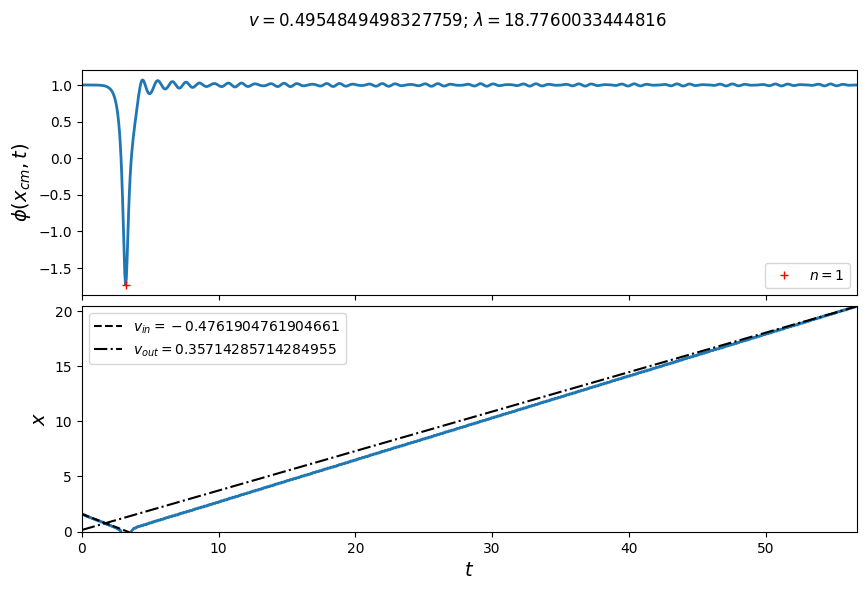

In [8]:
sample = summary.sample(1).iloc[0]
y_cm, trail = np.genfromtxt(sample.path, delimiter=',').T

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'hspace':0.05})

t = np.arange(len(y_cm))*Config.dt
ax1.plot(t, y_cm, lw=2)
ax2.plot(t, trail, lw=2)

peaks, _ = find_peaks(1 - y_cm, prominence=0.5)
ax1.plot(peaks*Config.dt, y_cm[peaks], 'r+', label=r'$n=%s$'%len(peaks))
ax1.legend()

v_in, v_out = velocity(trail)

ax2.plot(t, trail[0] + v_in*t, 'k--', label=r'$v_{in}=%s$'%v_in)
ax2.plot(t, trail[-1] + v_out*(t - len(trail)*Config.dt), 'k-.', label=r'$v_{out}=%s$'%v_out)
ax2.legend()

ax2.set_ylim(0, np.nanmax(trail))
ax2.set_xlim(0, len(trail)*Config.dt)

fig.suptitle(r'$v={}$; $\lambda={}$'.format(*sample.path.stem.split('-')[:2]))

ax1.set_ylabel(r'$\phi(x_{cm}, t)$')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$x$')
plt.show()

In [9]:
def plot_series_percentile(data: pd.DataFrame, x_col: str, y_col: str, percentile: tuple[float]=(5, 10, 25), 
                           alpha: tuple[float]=(0.2, 0.4, 0.8), ax: plt.Axes=None, label_format: str='%(p)s-%(pf)s %%', **kwargs) -> None:
    if ax == None: ax = plt.gca()
    group = data[[x_col, y_col]].groupby(x_col)
    for p, a in zip(percentile, alpha):
        pf = 100-p
        kwargs['label'] = label_format%{'p':str(p), 'pf':str(pf)}
        kwargs['alpha'] = a
        ax.fill_between(group.groups.keys(), np.squeeze(group.quantile(p/100).values), np.squeeze(group.quantile(pf/100).values), **kwargs)

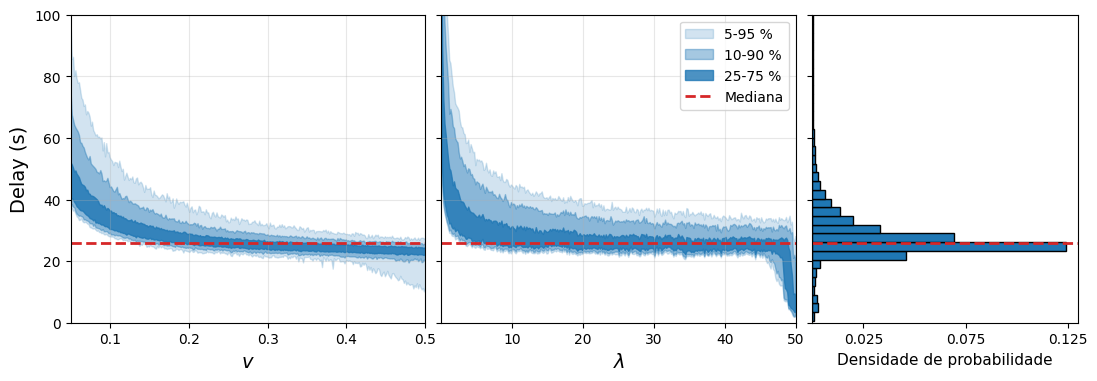

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4), sharey=True, gridspec_kw={'wspace': 0.05, 'width_ratios':[2, 2, 1.5]})

x_label = {'v': r'$v$', 'lamb': r'$\lambda$'}
for col, ax in zip(('v', 'lamb'), axs):

    plot_series_percentile(summary, col, 'delay', ax=ax, color='C0')

    x_lims = summary[col].min(), summary[col].max()
    ax.hlines(summary.delay.median(), *x_lims, linestyles='dashed', color='C3', lw=2, label='Mediana')

    ax.set_xlim(*x_lims)
    ax.set_xlabel(x_label[col])
    ax.grid(alpha=0.3)

axs[-1].hist(summary.delay, bins=150, density=True, edgecolor='k', orientation='horizontal')
axs[-1].hlines(summary.delay.median(), 0, 0.2, linestyles='dashed', color='C3', lw=2, label='Mediana')
axs[-1].set_xlim(0, 0.13)
axs[-1].set_xticks(axs[-1].get_xticks()[1::2])
axs[-1].set_xlabel('Densidade de probabilidade', fontsize=11)

axs[0].set_ylabel('Delay (s)')
axs[1].set_ylim(0, 100)
axs[1].legend() #bbox_to_anchor=(1.26, 1))

plt.show()

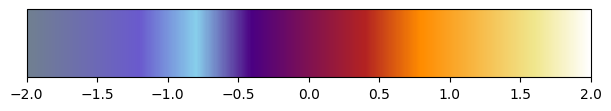

In [561]:
def linear_cmap(pcolors: tuple[str, float]):
    # pcolors = np.r_[pcolors]
    n_colors = len(pcolors)
    def wrapped(n):
        colors = []
        for i in range(n_colors):
            cf, pf = pcolors[i]
            if i == 0:
                colors += [mcolors.to_rgb(cf)]*int(n*pf)
            else:
                c0, p0 = pcolors[i-1]
                colors += np.stack([
                    np.linspace(v0, vf, int((pf-p0)*n)) 
                    for v0, vf in zip(mcolors.to_rgb(c0), mcolors.to_rgb(cf))
                ], axis=-1).tolist()
        colors += [mcolors.to_rgb(cf)]*int(n*(1-pf))
        return colors
    return wrapped

cmap = mcolors.ListedColormap(linear_cmap([
    # ('black', 0.0),
    # ('darkred', 0.0),
    # ('yellow', 0),
    ('white', 0),
    ('khaki', 0.1),
    ('darkorange', 0.3),
    ('firebrick', 0.4),
    # ('white', 0.5),
    ('indigo', 0.6),
    ('skyblue', 0.7),
    ('slateblue', 0.8),
    ('slategray', 1),
])(500)).reversed()

fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
fig.colorbar(plt.cm.ScalarMappable(mcolors.Normalize(vmin=-2, vmax=2), cmap), cax=ax, orientation='horizontal')

In [724]:
y = Config.collider.collide((-5, 5), (0.1, -0.1), 2, t_final=100)

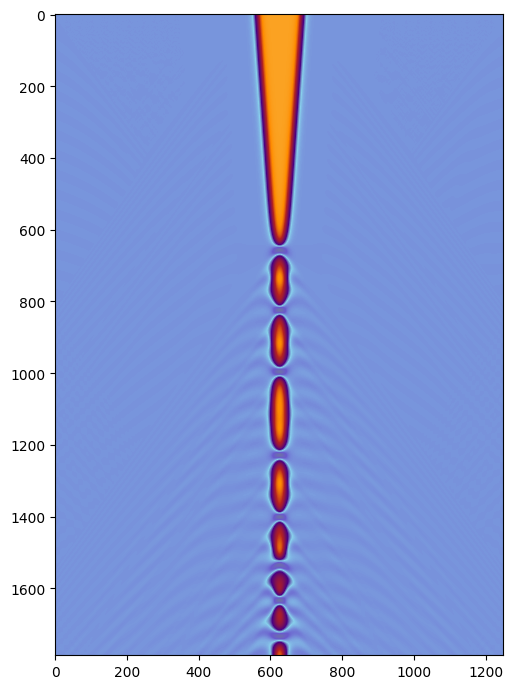

In [728]:
plt.figure(figsize=(7, 7))
plt.imshow(y, cmap=cmap, vmin=-2, vmax=2)
# 1 - y
plt.gcf().tight_layout()

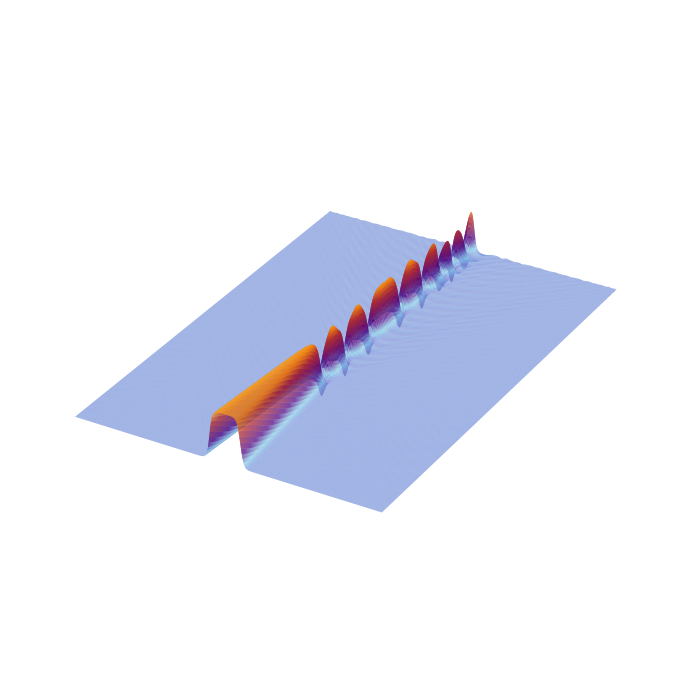

In [641]:
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111, projection='3d')
ax.axis('off')

scale = 100
ax.plot_surface(*np.meshgrid(*[np.arange(n) for n in y.shape[::-1]]), y*scale, 
                cmap=cmap, rstride=3, cstride=3, linewidth=1, alpha=1, 
                vmin=-2*scale, vmax=2*scale)
ax.set_aspect('equal')

fig.tight_layout()

In [ ]:
class ArrayBuilder:
    def __init__(self, dtype: np.dtype, shape: tuple):
        self.dtype = dtype
        self.shape = shape
        self._shared_array = mp.RawArray(np.ctypeslib.as_ctypes_type(dtype), int(np.prod(shape)))
    
    def to_numpy(self):
        return np.frombuffer(self._shared_array, dtype=self.dtype).reshape(self.shape)

In [ ]:
%%time
vs = np.linspace(*Config.v_lims, 300)
lambs = np.linspace(*Config.lamb_lims, 300)
len_summary = len(summary)

counter = mp.Value('i', 0)
shared_mosaic = ArrayBuilder(np.float64, (300, 300, 4))
def calc_mosaic(row):
    mosaic = shared_mosaic.to_numpy()
    path, v, lamb = row[:3]
    with counter.get_lock():
        counter.value += 1
        print(f'\r{(counter.value/len_summary*100):.2f}% - v={v} - lamb={lamb}', end='')
    y_cm, trail = np.genfromtxt(path, delimiter=',').T
    i, j = np.squeeze(np.argwhere(vs == v)), np.squeeze(np.argwhere(lambs == lamb))
    v_in, v_out = velocity(trail)
    mosaic[i, j, 0] = y_cm[-1]
    mosaic[i, j, 1] = v_in
    mosaic[i, j, 2] = v_out
    mosaic[i, j, 3] = len(find_peaks(1 - y_cm, prominence=0.5)[0])


with mp.Pool(processes=30) as pool:
    pool.map(calc_mosaic, summary.values)

0.01% - v=0.21103678929765884 - lamb=15.770484949832774

100.00% - v=0.4187290969899665 - lamb=40.98344481605350625CPU times: user 24.6 s, sys: 10.9 s, total: 35.5 s
Wall time: 1min 14s


In [ ]:
mosaic = shared_mosaic.to_numpy()
mosaic.shape

(300, 300, 4)

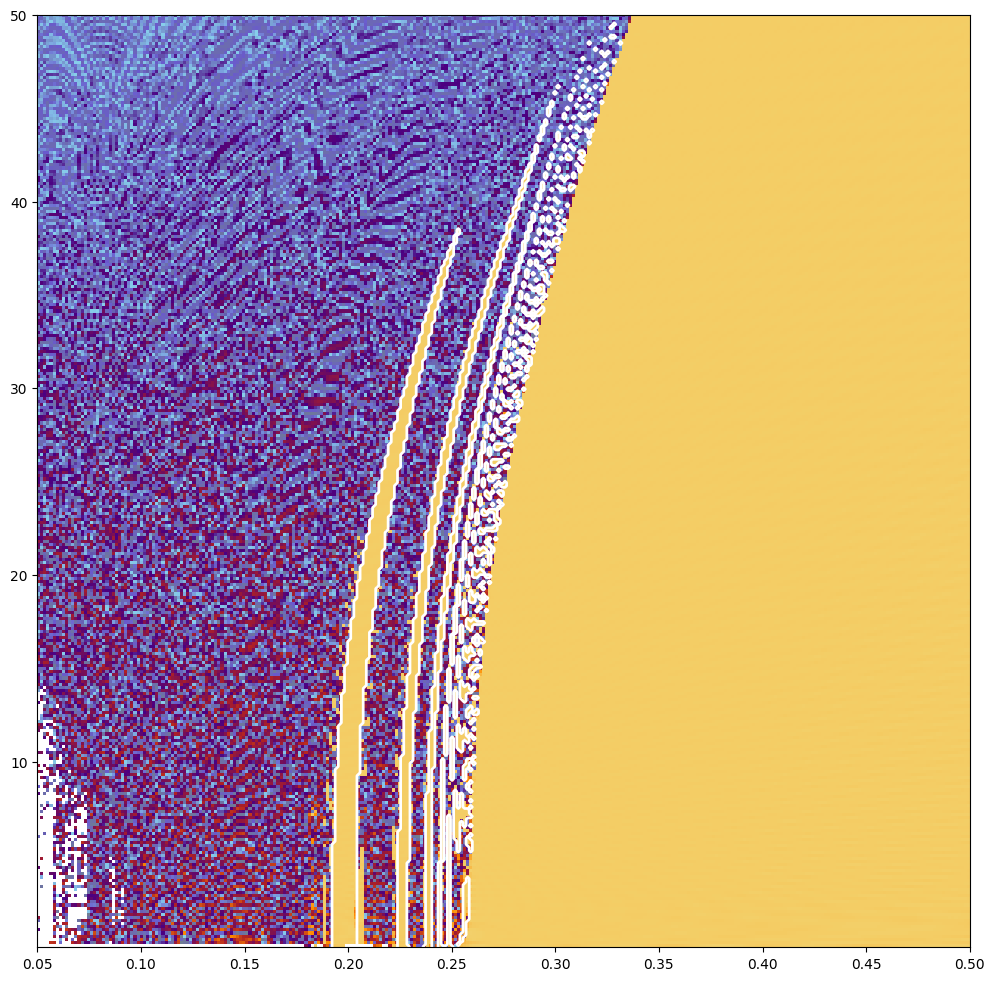

In [715]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(mosaic[..., 0].T, 
    extent=(*Config.v_lims, *Config.lamb_lims), 
    cmap=cmap,
    aspect=(Config.v_max - Config.v_min)/(Config.lamb_max - Config.lamb_min), 
    origin='lower', 
    resample=False,
    vmin=-1.7, vmax=1.5
)
plt.contour(*np.meshgrid(vs, lambs), mosaic[..., 3].T == 2, colors='w', linewidths=2)
fig.tight_layout()
plt.show()

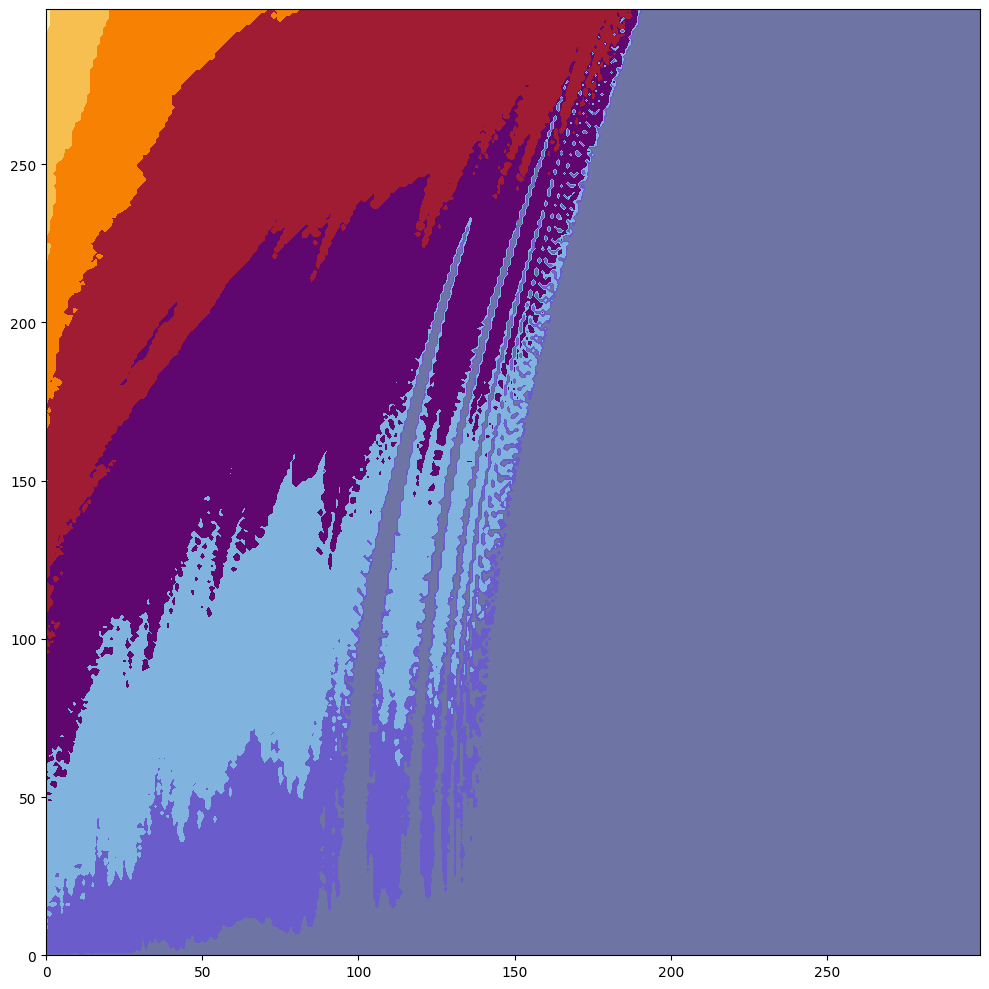

In [718]:
fig = plt.figure(figsize=(10, 10))
plt.contourf(mosaic[..., 3].T, cmap=cmap)
fig.tight_layout()
plt.show()

In [14]:
import psutil
import pandas as pd

In [15]:
for k, v in psutil.sensors_temperatures().items(): print(k); print(pd.DataFrame(v))

enp7s0
             label  current  high critical
0  PHY Temperature   63.207  None     None
1  MAC Temperature   69.474  None     None
nvme
       label  current    high  critical
0  Composite    38.85  117.85    149.85
coretemp
           label  current  high  critical
0   Package id 0     59.0  72.0      82.0
1        Core 11     54.0  72.0      82.0
2        Core 16     53.0  72.0      82.0
3        Core 17     53.0  72.0      82.0
4        Core 18     52.0  72.0      82.0
5        Core 19     56.0  72.0      82.0
6        Core 20     55.0  72.0      82.0
7        Core 24     55.0  72.0      82.0
8        Core 25     57.0  72.0      82.0
9        Core 26     54.0  72.0      82.0
10       Core 27     54.0  72.0      82.0
11        Core 0     52.0  72.0      82.0
12        Core 1     51.0  72.0      82.0
13        Core 2     58.0  72.0      82.0
14        Core 3     56.0  72.0      82.0
15        Core 4     56.0  72.0      82.0
16        Core 8     55.0  72.0      82.0
17        Core